In [1]:
# Final Script to create plots to put into the documentation.

import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

import warnings
warnings.filterwarnings('ignore')

To begin ODME - open the relevant project and demand matrix, and create the relevant graphs with any desired parameters.Here we use a sample project from 'Sioux Falls' with a single car user class. ODME can be performed with multiple user classes (although not multiple cores per class for the moment).

In [2]:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view() # Make sure to set the computational view appropriately.

The user must create a TrafficAssignment & TrafficClass objects and set their desired assignment parameters this is the assignment ODME will use when trying to make the assigned volumes conform to the user input count volumes. If an invalid assignment object is given ODME will not guarantee any particular behaviour - see TrafficAssignment (REFERENCE HERE) for more information on that.

In [3]:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5

# NOTE - Until Issue #493 is resolved algorithms cfw & bfw cannot be used for assignment.
assignment.set_algorithm("msa")

Now we need to produce a set of count data - in practise this will be determined experimentally. For now, we will run an assignment and change the assigned volumes by up to 3% (this will ensure the ODME procedure has something to do) for an arbitrarily chosen set of links to synthetically generate our data. See TrafficAssignment (REFERENCE HERE) for information on the assignment execution.

In [4]:
# The set of links for our counts:
links = [1, 14, 17, 25, 38]

assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
flow = lambda link: assign_df.loc[assign_df["link_id"] == link, "matrix_ab"].values[0]

# The columns to our data dataframe must be: 'class', 'link_id', 'direction', 'obs_volume'
# where 'obs_volume' is the count data.
columns = ODME.COUNT_VOLUME_COLS

# Synthetically generated data (changing counts by upto a 5% increase):
random.seed(0)
data = [["car", link, 1, flow(link) * random.uniform(1, 1.05)] for link in links]

counts = pd.DataFrame(data=data, columns=columns)

Now that we have generated our data, we can now set our parameters for ODME. Feel free to use any of the algorithms available (see ODME.ALL_ALGORITHMS) and experiment with the stopping criteria. Stopping criteria if specified must be in the format shown below.

In [5]:
# We will run a quick ODME procedure:
stop_crit = {"max_outer": 10,
    "max_inner": 40,
    "convergence_crit": 1,
    "inner_convergence": 0.1}

odme = ODME(assignment,
    counts,
    stop_crit=stop_crit,
    algorithm="spiess"
    )

We can now run the ODME procedure. Note that when we execute ODME it will make a copy of all input matrices and leave the original matrices unchanged.

In [6]:
odme.execute(verbose=True, print_rate=2) # Verbose allows us to track the progress of ODME as it occurs

Outer iteration 5 is complete.
Outer iteration 10 is complete.


If we wish to we can save the results using the save_to_project() method which will both save the results and generate a procedure report (NOT YET IMPLEMENTED).

In [7]:
# If we wish to save the project we can call the following function -
# (saving as both .omx or .aem are supported)
odme.save_to_project("example_doc", "example_doc.omx", project=project)

From here, we can use the methods below to extract and then visualise/process the results (without saving them). To access the matrices themselves directly use the TrafficAssignment object to access the new TrafficClasses within which the matrices are contained.

In [8]:
# To get the demand matrices as a list of numpy arrays:
new_demands = odme.get_demands()

# A dataframe containing extensive statistics for each count volume and iteration:
stats = odme.get_all_statistics() # use stats.columns to see all data provided

# A dataframe containing summary statistics on the factors applied to each demand matrix over each iteration:
iterative_factors = odme.get_iteration_factors()

# An unordered list of cumulative factors applied to each demand matrix
# (the same as dividing the final demand matrix by the initial demand)
cumulative_factors = odme.get_cumulative_factors()

From here the results can be analysed by the user - we will provide a few sample plots of what can be visualised.

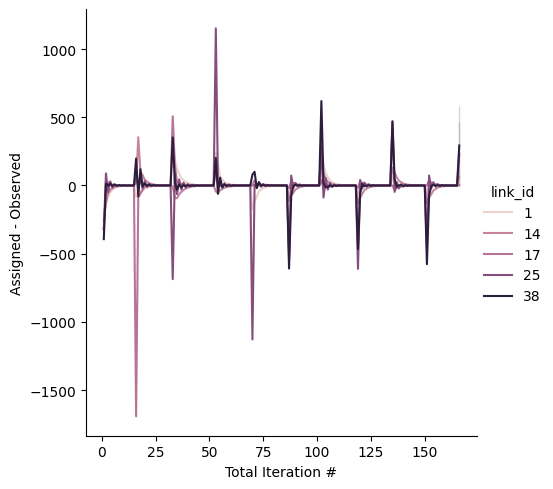

In [9]:
# Plotting all count volumes across iterations:
sns.relplot(x='Total Iteration #',
    y='Assigned - Observed',
    hue='link_id', 
    kind='line', 
    data=stats, 
    markers=True, 
    dashes=False)

<Axes: xlabel='Factors', ylabel='Count'>

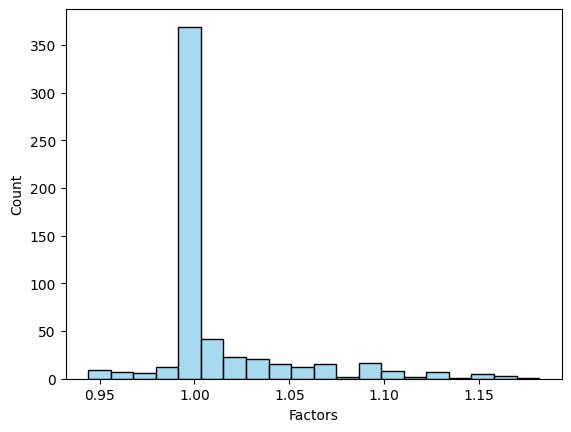

In [10]:
# Plotting a histogram to visualise the total (cumulative) factors applied to the matrix:
sns.histplot(cumulative_factors['Factors'], bins=20, kde=False, color='skyblue')

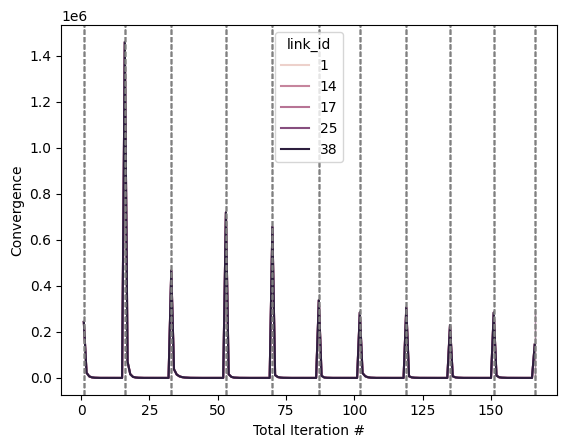

In [11]:
# Plotting how the objective function changes across iterations:
sns.lineplot(x='Total Iteration #',
    y='Convergence',
    hue='link_id', 
    data=stats, 
    markers=True, 
    dashes=False)

# We can extract and visualise when each new outer iteration begins:
outer_iterations = stats[stats["Inner Loop #"] == 0]["Total Iteration #"]
for outer_iteration in outer_iterations:
    plt.axvline(x=outer_iteration, color='gray', linestyle='--', linewidth=1)

Finally we close the project and matrices:

In [12]:
matrix.close()
project.close()